<a href="https://colab.research.google.com/github/syq-tju/Bert/blob/main/Bert3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers torch scikit-learn


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 加载数据
data = pd.read_csv('./imdbs.csv')  # 使用正确的路径
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size=0.1, random_state=42)


In [3]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import torch

# 初始化 tokenizer 和 model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Tokenization
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=512)

# 转换为 torch dataset
train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']), torch.tensor(train_encodings['attention_mask']), torch.tensor(y_train.values))
test_dataset = TensorDataset(torch.tensor(test_encodings['input_ids']), torch.tensor(test_encodings['attention_mask']), torch.tensor(y_test.values))


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
from torch.optim import AdamW
from transformers import get_scheduler
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
optim = AdamW(model.parameters(), lr=1e-5)

num_epochs = 20
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler("linear", optimizer=optim, num_warmup_steps=0, num_training_steps=num_training_steps)

model.train()
for epoch in range(num_epochs):
    for batch in train_loader:
        # 更新这里的批次处理方式
        input_ids, attention_mask, labels = [tensor.to(device) for tensor in batch]

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()

        optim.step()
        lr_scheduler.step()
        optim.zero_grad()

        print(f"Epoch: {epoch}, Loss: {loss.item()}")


Epoch: 0, Loss: 0.011813975870609283
Epoch: 0, Loss: 0.013225291855633259
Epoch: 0, Loss: 0.011208174750208855
Epoch: 0, Loss: 0.009458571672439575
Epoch: 0, Loss: 0.008070779033005238
Epoch: 0, Loss: 0.010138371028006077
Epoch: 0, Loss: 0.007704258430749178
Epoch: 0, Loss: 0.007010070141404867
Epoch: 0, Loss: 0.006595974788069725
Epoch: 0, Loss: 0.0050117867067456245
Epoch: 0, Loss: 0.006049966439604759
Epoch: 0, Loss: 0.005655188579112291
Epoch: 1, Loss: 0.006603015586733818
Epoch: 1, Loss: 0.004771417938172817
Epoch: 1, Loss: 0.0035569719038903713
Epoch: 1, Loss: 0.0047248550690710545
Epoch: 1, Loss: 0.0039009570609778166
Epoch: 1, Loss: 0.003919094335287809
Epoch: 1, Loss: 0.003292639972642064
Epoch: 1, Loss: 0.003140582237392664
Epoch: 1, Loss: 0.0037586400285363197
Epoch: 1, Loss: 0.003500710939988494
Epoch: 1, Loss: 0.0030736045446246862
Epoch: 1, Loss: 0.002740195021033287
Epoch: 2, Loss: 0.0027477070689201355
Epoch: 2, Loss: 0.002667754888534546
Epoch: 2, Loss: 0.0030064901802

Epoch: 0, Loss: 0.00019294764175962578, Accuracy: 1.0
Epoch: 1, Loss: 2.8463197395467432e-05, Accuracy: 1.0
Epoch: 2, Loss: 1.0665442914614687e-05, Accuracy: 1.0
Epoch: 3, Loss: 6.747718278650912e-06, Accuracy: 1.0
Epoch: 4, Loss: 5.611511710412742e-06, Accuracy: 1.0
Epoch: 5, Loss: 4.605689468917262e-06, Accuracy: 1.0
Epoch: 6, Loss: 4.377206058355417e-06, Accuracy: 1.0
Epoch: 7, Loss: 4.05807414457134e-06, Accuracy: 1.0
Epoch: 8, Loss: 3.858151160329726e-06, Accuracy: 1.0
Epoch: 9, Loss: 3.782403913040374e-06, Accuracy: 1.0


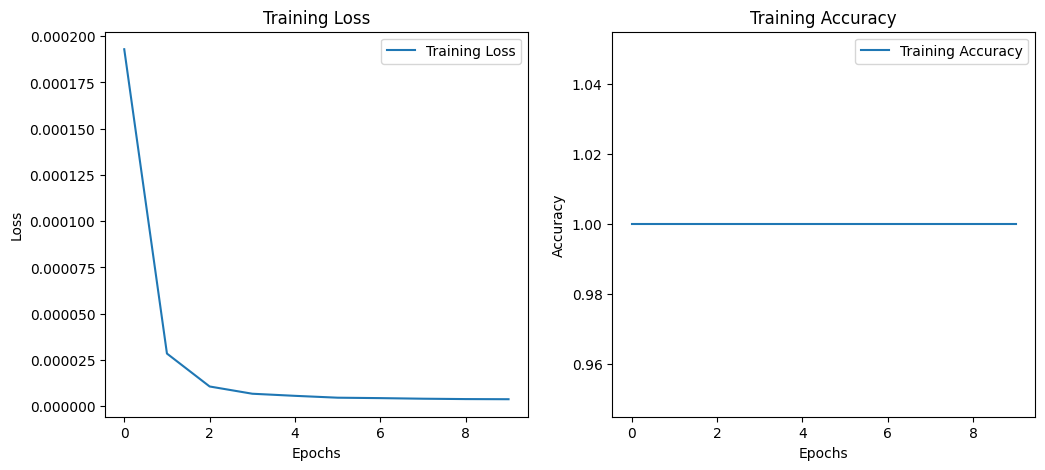

In [17]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import get_scheduler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
optim = AdamW(model.parameters(), lr=5e-5)

num_epochs = 10
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler("linear", optimizer=optim, num_warmup_steps=0, num_training_steps=num_training_steps)

model.train()

# 初始化损失和准确率列表
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for batch in train_loader:
        input_ids, attention_mask, labels = [tensor.to(device) for tensor in batch]

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        correct_predictions += (preds == labels).sum().item()
        total_predictions += labels.size(0)

        loss.backward()
        optim.step()
        lr_scheduler.step()
        optim.zero_grad()

    # 计算平均损失和准确率
    avg_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_predictions

    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)

    print(f"Epoch: {epoch}, Loss: {avg_loss}, Accuracy: {accuracy}")

# 绘制损失和准确率图
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
